In [0]:
%%bash
if [ ! -f "random-forest-apps.parquet" ]; then
  wget -q https://github.com/hmatalonga/farmer-showcase/raw/master/data/random-forest-apps.parquet
fi

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pyarrow.parquet as pq

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

sns.set_style('whitegrid')

print(tf.__version__)

1.14.0


In [0]:
%load_ext google.colab.data_table

In [0]:
def load_df(path, columns=None, use_threads=True, strings_to_categorical=True):
  """
  Load a parquet file and returns a pandas DataFrame
  """
  try:
    table = pq.read_table(path, columns=columns, use_threads=use_threads)
    return table.to_pandas(strings_to_categorical=strings_to_categorical)
  except Exception as e:
      print(e)


def save_df(df, path, compression='snappy', use_dictionary=True):
  """
  Save a pandas DataFrame to a parquet file
  """
  try:
    df.to_parquet(path, compression=compression,
                  use_dictionary=use_dictionary)
  except Exception as e:
    print(e)


def truncate(n, decimals=0):
    multiplier = 10 ** decimals
    return int(n * multiplier) / multiplier

In [0]:
df = load_df('random-forest-apps.parquet')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397008 entries, 0 to 397007
Data columns (total 20 columns):
name                   397008 non-null category
application_label      397008 non-null category
importance             397008 non-null category
version_code           397008 non-null int64
battery_state          397008 non-null category
battery_level          397008 non-null uint8
network_status         397008 non-null category
screen_brightness      397008 non-null int64
screen_on              397008 non-null uint8
charger                397008 non-null category
current_average        397008 non-null int64
health                 397008 non-null category
temperature            397008 non-null float32
usage                  397008 non-null float32
bluetooth_enabled      397008 non-null uint8
location_enabled       397008 non-null uint8
power_saver_enabled    397008 non-null uint8
flashlight_enabled     397008 non-null uint8
nfc_enabled            397008 non-null uint8
voltage  

In [0]:
df = df.drop(['application_label', 'importance', 'version_code'], axis=1)
df = df.rename(columns={'usage': 'cpu_usage'})

In [0]:
df['cpu_usage'] = (df['cpu_usage'] * 100).astype('uint8')

#### Remove CPU faulty values

In [0]:
df = df[df['cpu_usage'].between(0, 100)]

#### Truncate unit values

In [0]:
df['cpu_usage'] = df['cpu_usage'].apply(lambda x: truncate(x, 2))
df['voltage'] = df['voltage'].apply(lambda x: x / 1000 if x > 1000 else x)
df['voltage'] = df['voltage'].apply(lambda x: truncate(x, 2))
df['temperature'] = df['temperature'].apply(lambda x: truncate(x, 2))

#### Label encoding for apps names 

In [0]:
df['name'] = df['name'].cat.codes

#### One-Hot encoding for categorical values

In [0]:
df = pd.get_dummies(df, columns=['battery_state', 'network_status',
                                 'charger', 'health'])

In [0]:
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)

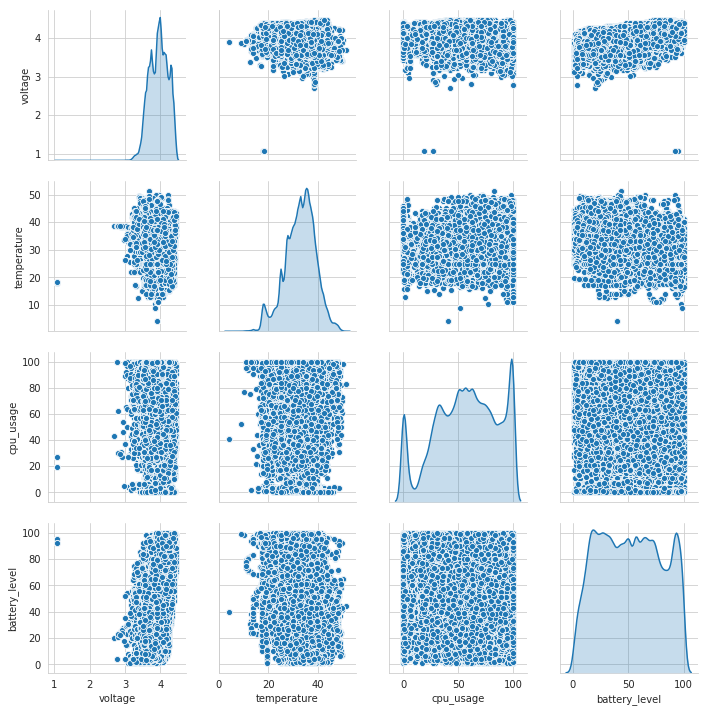

In [14]:
features = ['voltage', 'temperature', 'cpu_usage', 'battery_level']
sns.pairplot(train_dataset[features], diag_kind='kde')

In [15]:
train_stats = train_dataset.describe()
train_stats.pop('voltage')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
name,314690.0,422.574540,457.724234,0.0,40.0,239.0,709.0,1693.00
battery_level,314690.0,52.218917,27.415990,1.0,29.0,52.0,75.0,100.00
screen_brightness,314690.0,99.069249,102.962419,-1.0,8.0,45.0,217.0,255.00
screen_on,314690.0,0.441959,0.496621,0.0,0.0,0.0,1.0,1.00
current_average,314690.0,-791.488392,30181.378993,-1358916.0,0.0,0.0,300.0,650520.00
temperature,314690.0,32.824609,6.002351,4.0,29.0,33.2,37.0,51.29
cpu_usage,314690.0,57.428879,28.054354,0.0,37.0,58.0,80.0,100.00
bluetooth_enabled,314690.0,0.122800,0.328208,0.0,0.0,0.0,0.0,1.00
location_enabled,314690.0,0.393765,0.488585,0.0,0.0,0.0,1.0,1.00
power_saver_enabled,314690.0,0.064359,0.245391,0.0,0.0,0.0,0.0,1.00


In [0]:
train_labels = train_dataset.pop('voltage')
test_labels = test_dataset.pop('voltage')

In [0]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [19]:
model = build_model()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2240      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 6,465
Trainable params: 6,465
Non-trainable params: 0
_________________________________________________________________


In [21]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [0]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [23]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])


........................

In [24]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
19,0.067043,0.213770,0.067043,0.067217,0.214525,0.067217,19
20,0.067040,0.213758,0.067040,0.067202,0.214465,0.067202,20
21,0.067036,0.213760,0.067036,0.067233,0.214581,0.067233,21
22,0.067044,0.213780,0.067044,0.067272,0.214758,0.067272,22
23,0.067042,0.213772,0.067042,0.067183,0.214227,0.067183,23


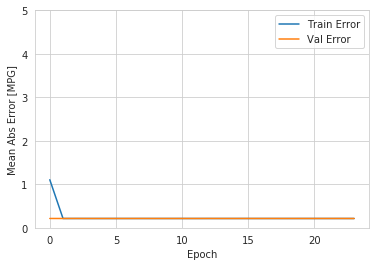

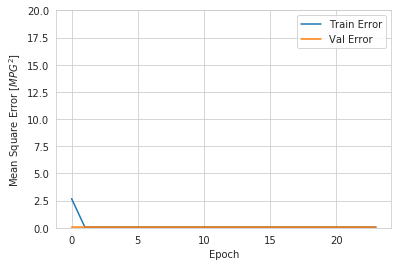

In [25]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

In [30]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:3.2f} voltage".format(mae))
print("Testing set Mean Std Error: {:3.2f} voltage".format(mse))
print("Testing set Loss: {:3.2f} voltage".format(loss))

Testing set Mean Abs Error: 0.21 voltage
Testing set Mean Std Error: 0.07 voltage
Testing set Loss: 0.07 voltage


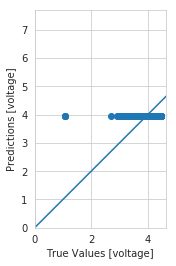

In [27]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [voltage]')
plt.ylabel('Predictions [voltage]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

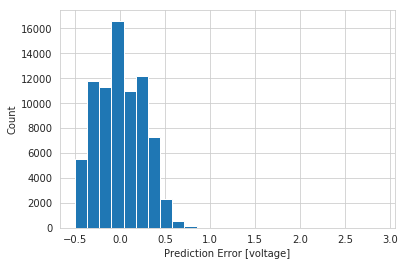

In [28]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [voltage]")
_ = plt.ylabel("Count")